## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [1]:
import sys
sys.path.append('../')
# pipeline functions
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [ ]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')
# see how many "good cells" Ken labeled (1)
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [3]:
%%time
# preprocess data with fcc recipe
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^mt-', n_hvgs=2000)

../QC.py:122: UserWarning: Encountered 10361 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


CPU times: user 7.8 s, sys: 2.1 s, total: 9.9 s
Wall time: 9.91 s


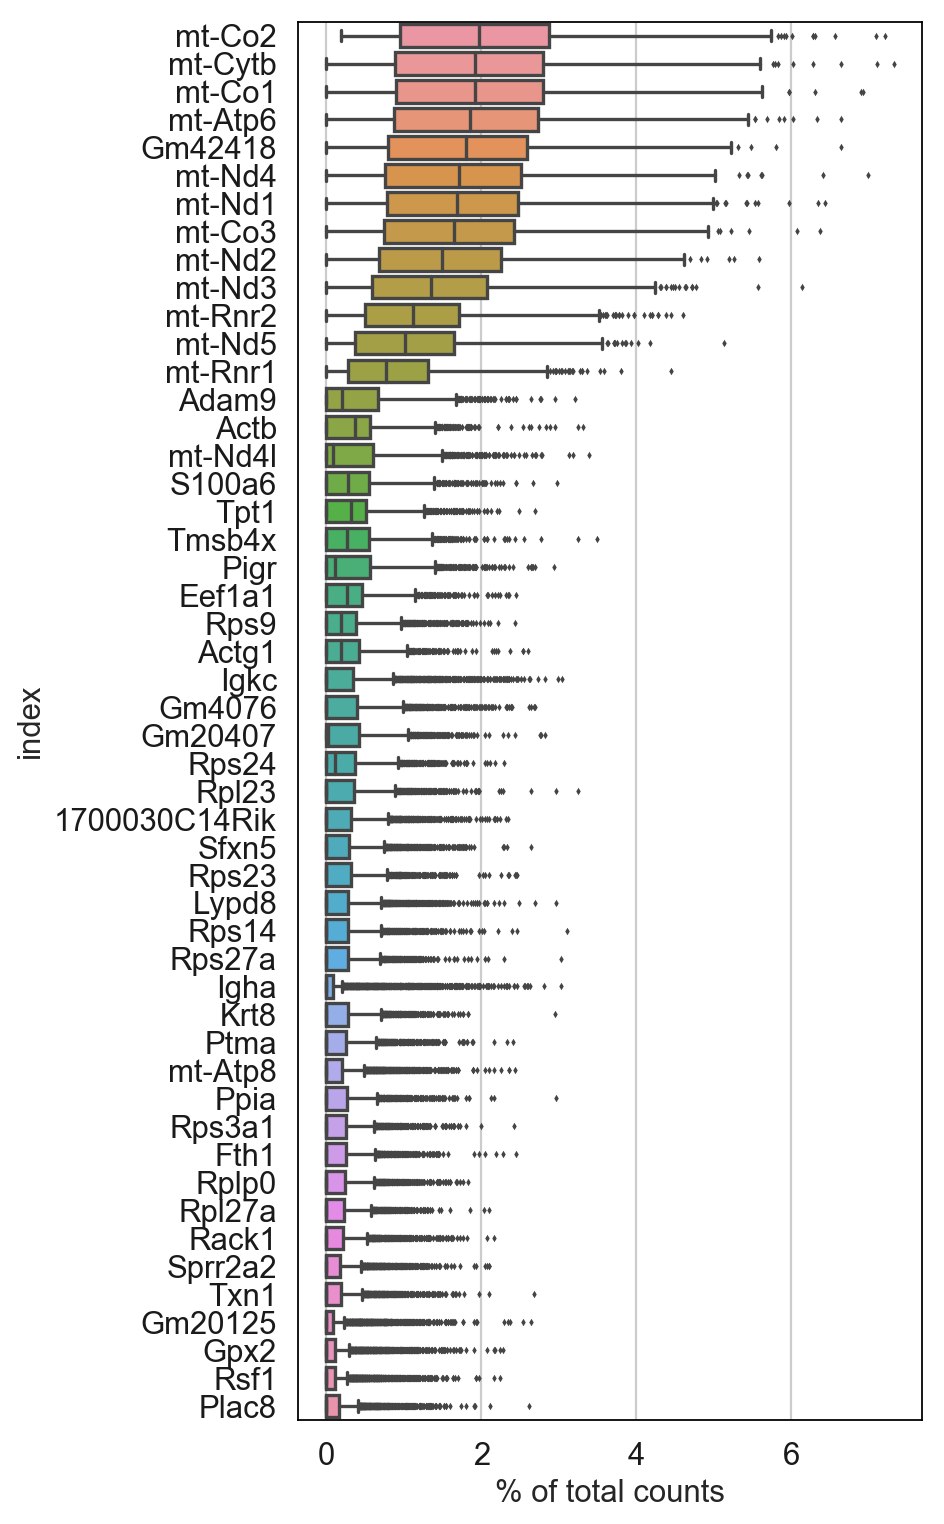

In [4]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=50)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [5]:
s1_thresh = auto_thresh_obs(s1, method="li", obs_cols=["arcsinh_n_genes_by_counts","pct_counts_mito"])

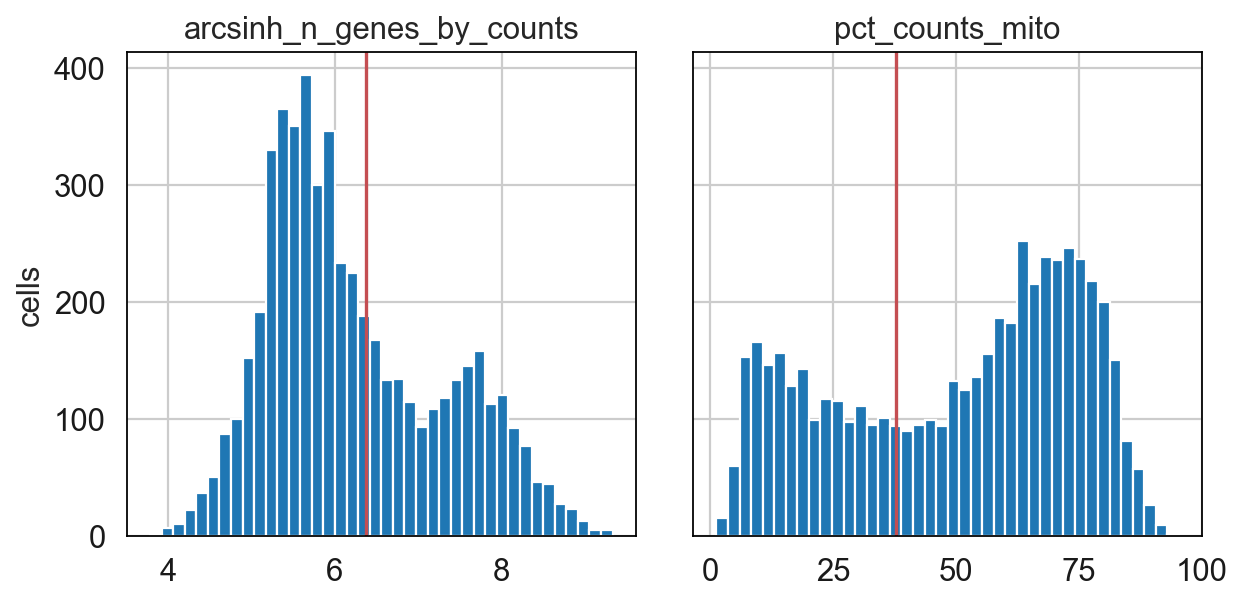

In [6]:
plot_thresh_obs(s1, s1_thresh)

### a couple different ways of visualizing these thresholds vs Ken's filter...

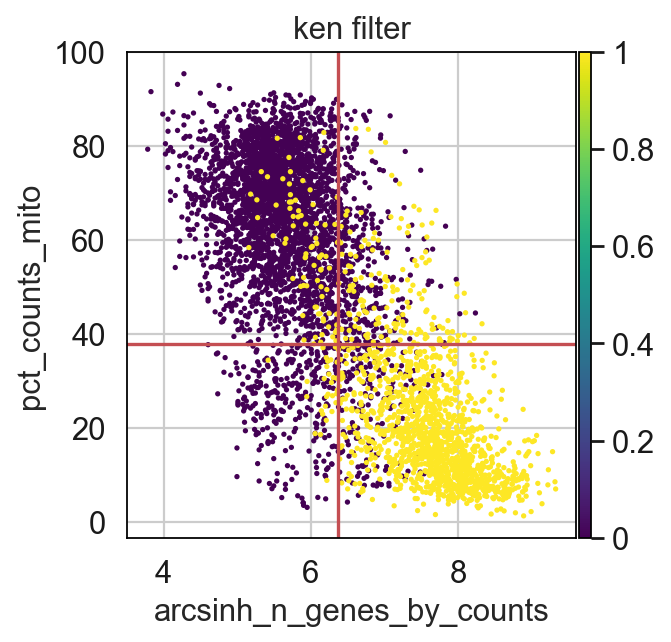

In [9]:
ax = sc.pl.scatter(adata=s1, x='arcsinh_n_genes_by_counts', y='pct_counts_mito', color='ken_filter', show=False)
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to Ken's labels

In [15]:
%%time
filter_thresh_obs(s1, 
                  s1_thresh,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_mito'], 
                  directions=['above','below'],
                  name='thresh_filter'
                 )

CPU times: user 5.62 ms, sys: 821 µs, total: 6.44 ms
Wall time: 5.7 ms


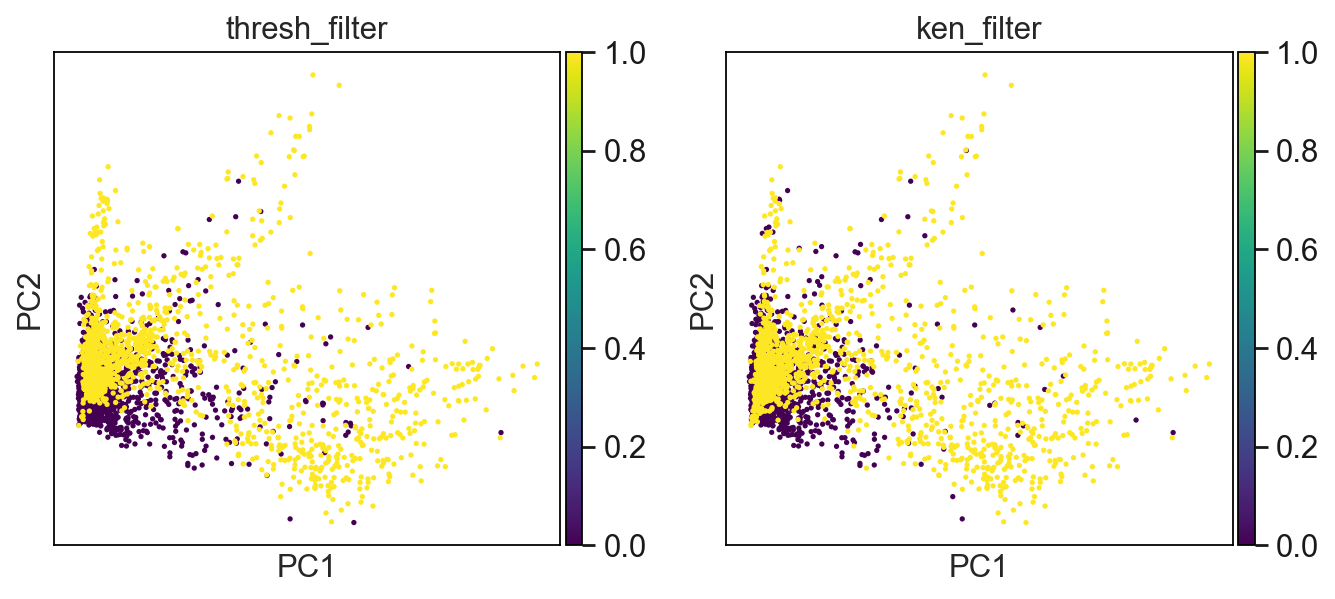

CPU times: user 2.89 s, sys: 598 ms, total: 3.49 s
Wall time: 858 ms


In [16]:
%%time
# perform 10-component PCA (for training our classifiers later) and look at the two filter labels side-by-side
sc.tl.pca(s1, n_comps=10)
sc.pl.pca(s1, color=['thresh_filter','ken_filter'])

#### Look at set differences with `ken_filter`:

In [17]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

166

In [18]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['thresh_filter']==1])))

261

In [19]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]) ^ set(s1.obs_names[s1.obs['ken_filter']==1]))

427

---
#### ~400 cell difference isn't bad with hard thresholding. Let's train a two-step PU classifier to reconfigure these labels.
#### First, pick reliable positives, or "bad" cells based on the above thresholds.
#### Below defines probabilities for random sampling these training cells

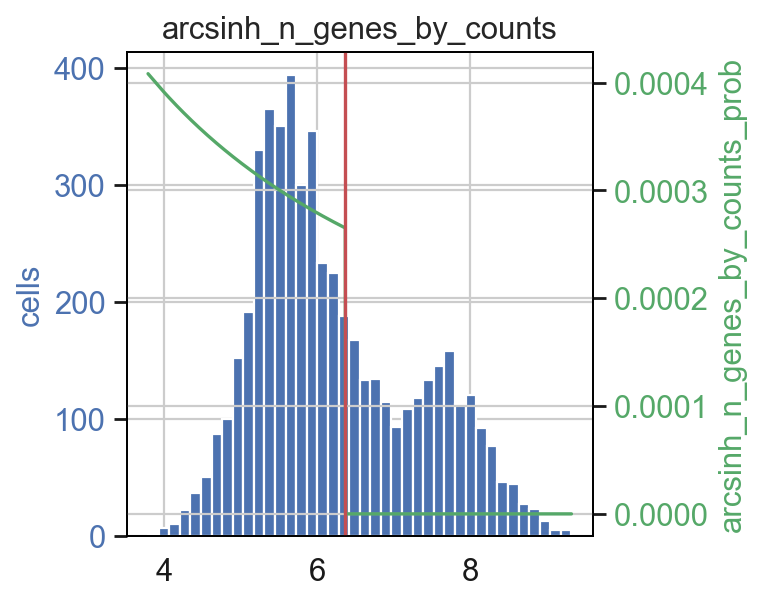

In [21]:
sampling_probabilities(s1, 'arcsinh_n_genes_by_counts', s1_thresh['arcsinh_n_genes_by_counts'], direction='below')

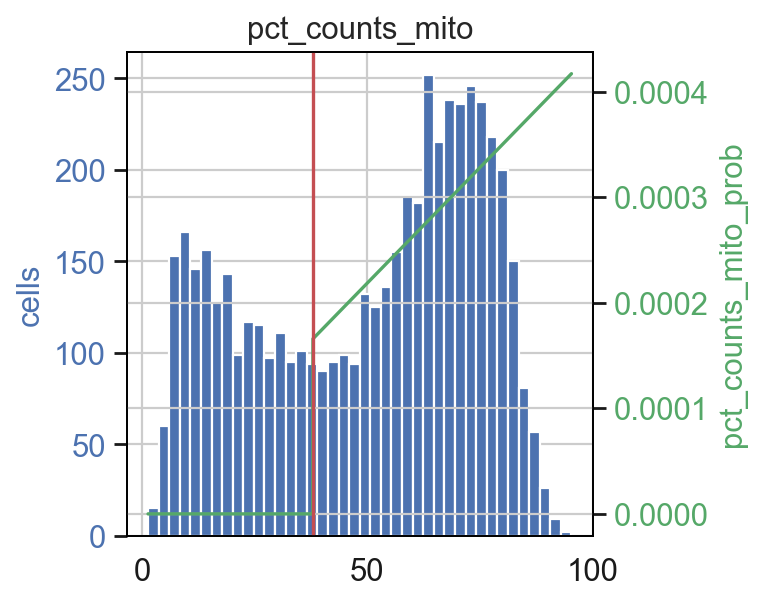

In [22]:
sampling_probabilities(s1, 'pct_counts_mito', s1_thresh['pct_counts_mito'], direction='above')

#### combine probabilities for training set (bad/empty cells):

In [23]:
# combine and normalize probabilities
s1.obs['train_prob'] = s1.obs['arcsinh_n_genes_by_counts_prob'] + s1.obs['pct_counts_mito_prob']

s1.obs['train_prob'] /= s1.obs['train_prob'].sum()

#### A couple ways of visualizing these probabilities

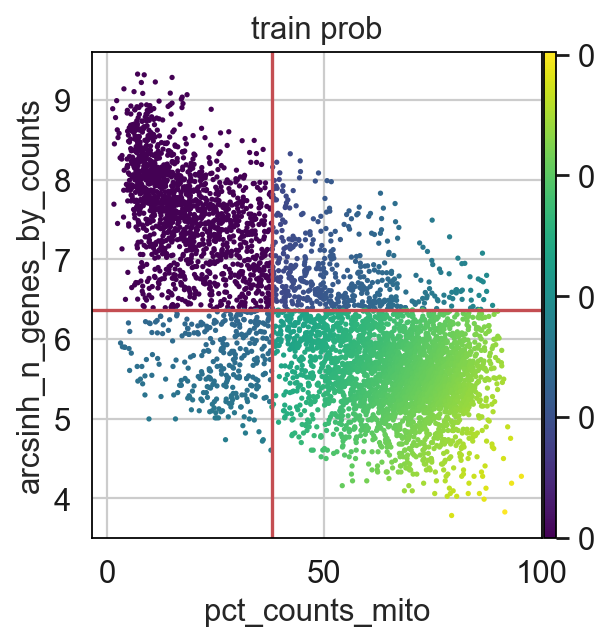

In [25]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='train_prob', show=False)
ax.axvline(s1_thresh['pct_counts_mito'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

---
#### Now, determine probabilities for picking reliable negatives, or "good" cells based on the same thresholds (in the opposite directions)

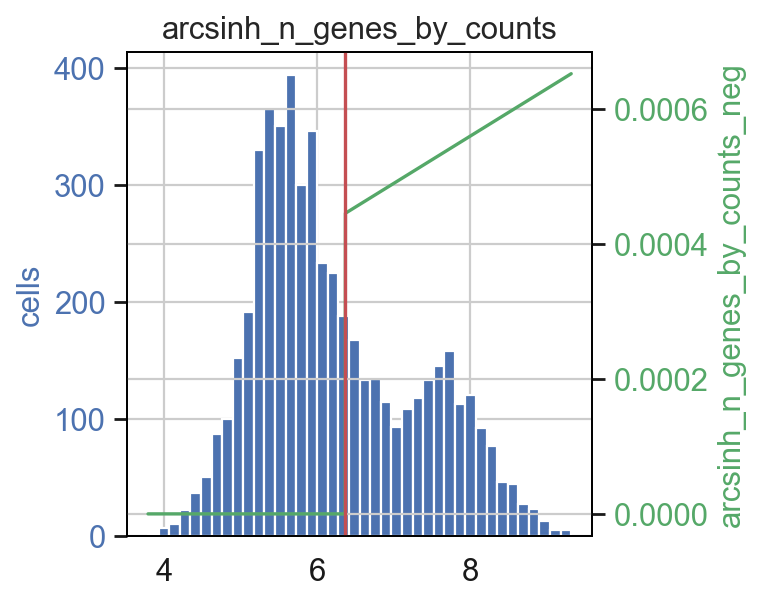

In [26]:
sampling_probabilities(s1, 'arcsinh_n_genes_by_counts', s1_thresh['arcsinh_n_genes_by_counts'], direction='above', inclusive=False, suffix='neg')

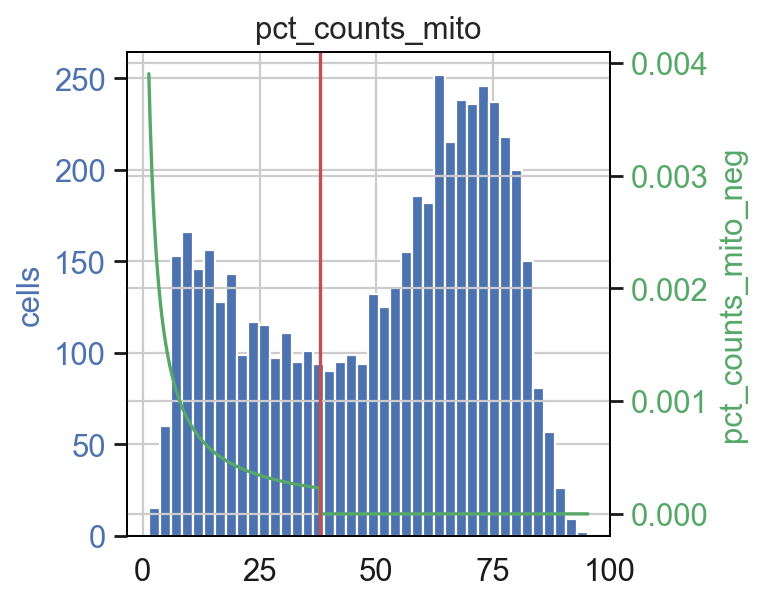

In [27]:
sampling_probabilities(s1, 'pct_counts_mito', s1_thresh['pct_counts_mito'], direction='below', inclusive=False, suffix='neg')

#### combine probabilities for training set (good cells):

In [28]:
# combine and normalize probabilities
s1.obs['train_neg'] = s1.obs['arcsinh_n_genes_by_counts_neg'] + s1.obs['pct_counts_mito_neg']

s1.obs['train_neg'] /= s1.obs['train_neg'].sum()

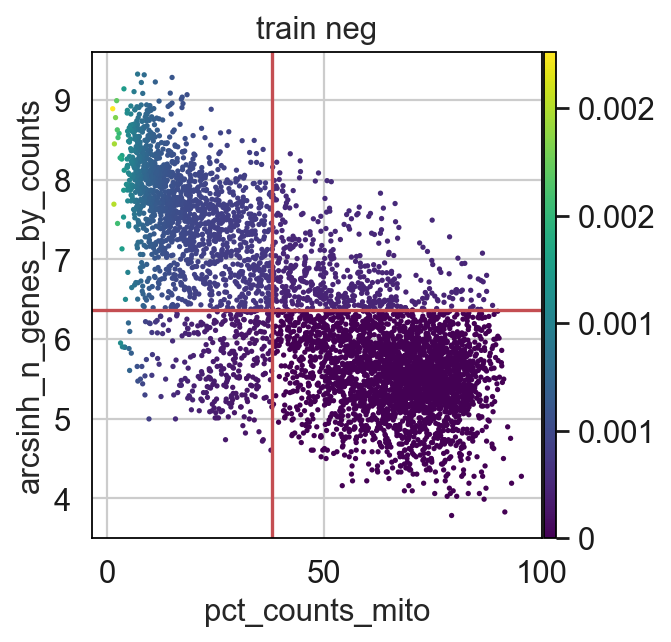

In [29]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='train_neg', show=False)
ax.axvline(s1_thresh['pct_counts_mito'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

---
#### Randomly sample training set (reliable "positives" or dead/empty cells), and reliable "negative" set or likely good cells

In [30]:
generate_training_labels(
    s1,
    pos_prob=s1.obs['train_prob'],
    pos_size=int(0.70*(s1.n_obs - s1.obs['thresh_filter'].sum())),
    neg_prob=s1.obs['train_neg'],
    neg_size=int(0.25*s1.obs['thresh_filter'].sum()),
    name='train',
    seed=18
)
# NOTE: Look at the fractions chosen within "size" parameter. I've noticed that a higher fraction (0.5-0.7)
#       is better for positives (bad cells), with a lower fraction (0.2-0.4) chosen for negatives (good cells)

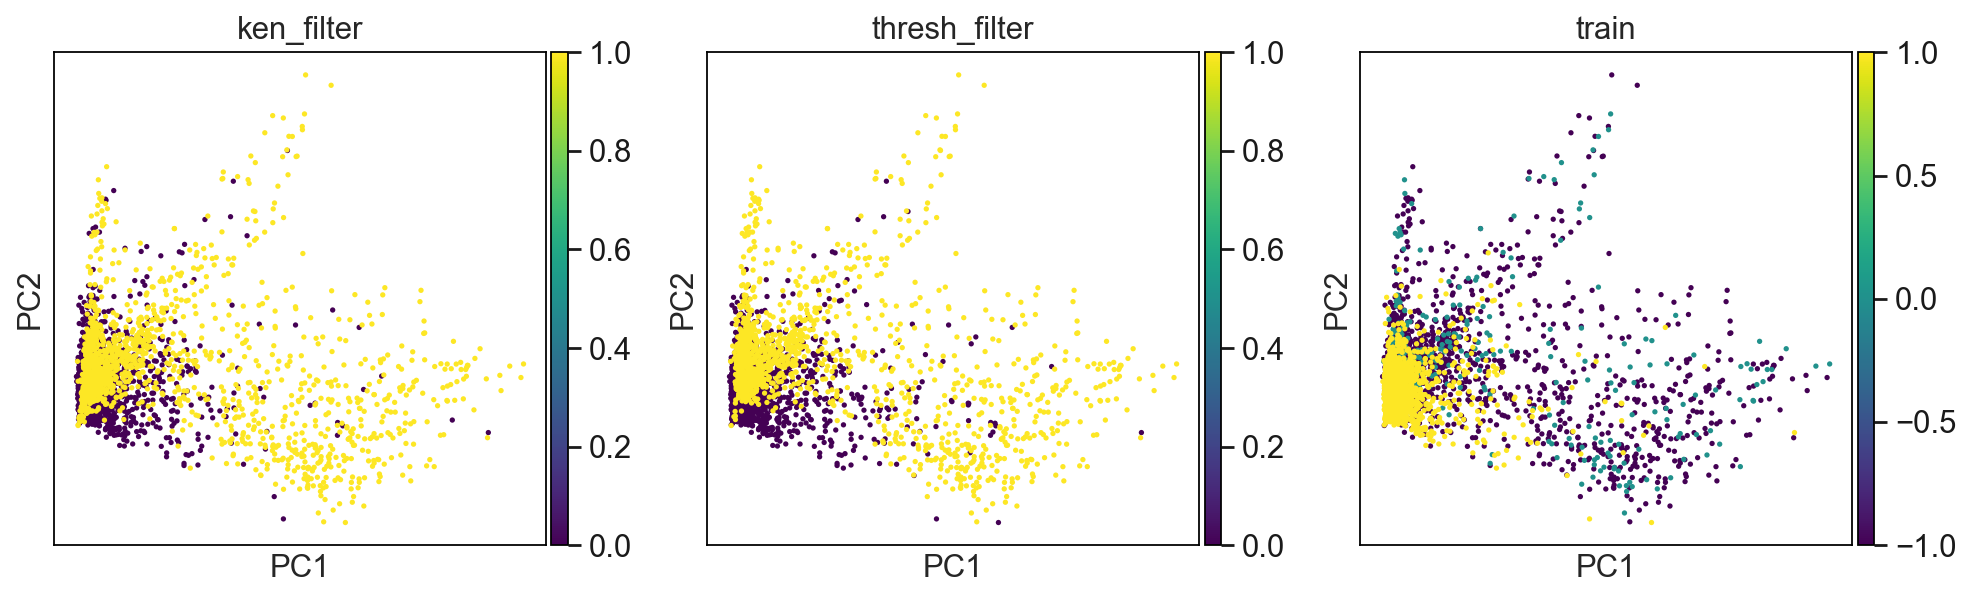

In [31]:
# -1: unlabeled
# 1: positive (dead/empty)
# 0: negative (live)

sc.pl.pca(s1, color=['ken_filter','thresh_filter','train'])

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [32]:
len(set(s1.obs.loc[s1.obs['train']==1].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==0].index)))

144

In [33]:
len(set(s1.obs.loc[s1.obs['train']==0].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==1].index)))

66

In [34]:
s1.obs['train'].value_counts()

 1    2671
-1    2258
 0     328
Name: train, dtype: int64

---
#### get training set and labels for two-step learning method:

In [35]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['train'].copy(deep=True) # training labels are from .obs df

In [36]:
%%time
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1) # define classifier
s1.obs['twostep_scores'], s1.obs['twostep_labels'] = twoStep(clf=rf, X=X, y=y, thresh='min', n_iter=18)

Step 1 labeled 1171 new positives and 886 new negatives. 201 unlabeled remaining.
Iteration 1: Doing step 2... Step 1 labeled 41 new positives and 71 new negatives. 89 unlabeled remaining.
Iteration 2: Doing step 2... Step 1 labeled 12 new positives and 31 new negatives. 46 unlabeled remaining.
Iteration 3: Doing step 2... Step 1 labeled 6 new positives and 2 new negatives. 38 unlabeled remaining.
Iteration 4: Doing step 2... Step 1 labeled 0 new positives and 3 new negatives. 35 unlabeled remaining.
Iteration 5: Doing step 2... Step 1 labeled 2 new positives and 1 new negatives. 32 unlabeled remaining.
Iteration 6: Doing step 2... Step 1 labeled 3 new positives and 1 new negatives. 28 unlabeled remaining.
Iteration 7: Doing step 2... Step 1 labeled 1 new positives and 3 new negatives. 24 unlabeled remaining.
Iteration 8: Doing step 2... Step 1 labeled 0 new positives and 1 new negatives. 23 unlabeled remaining.
Iteration 9: Doing step 2... Step 1 labeled 0 new positives and 2 new nega

#### predict the remaining unlabeled cells using the trained (and re-trained) RandomForestClassifier():

In [37]:
s1.obs.loc[y==-1, 'twostep_labels'] = rf.predict(X[y==-1]) 

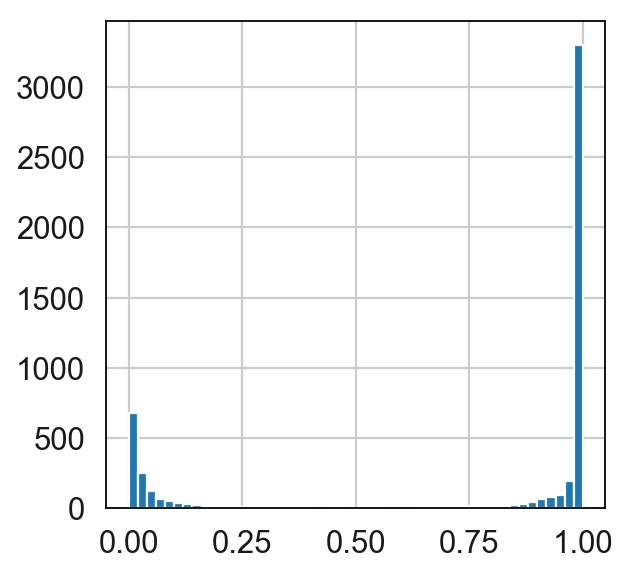

In [38]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['twostep_scores'], bins=50)

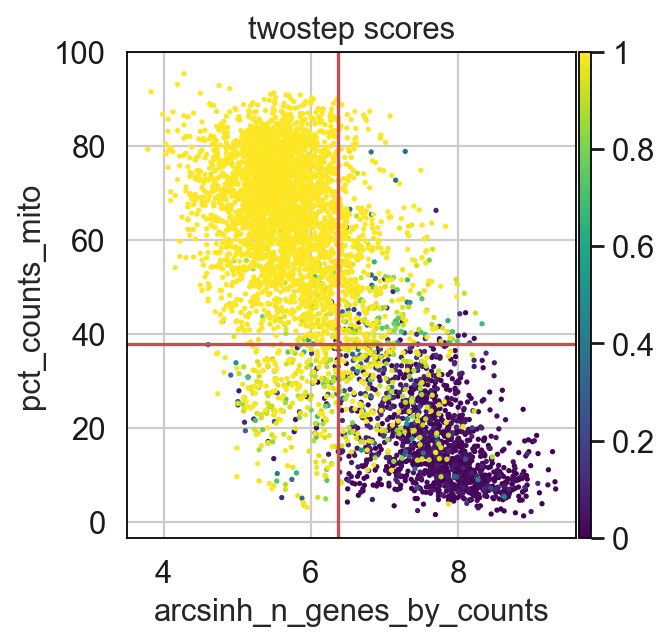

In [40]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='twostep_scores', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
plt.show()

In [41]:
# flip our labels to match Ken's (1: good cell, 0: bad cell)
s1.obs['twostep_labels_flip'] = (~s1.obs['twostep_labels'].astype(bool)).astype(int)

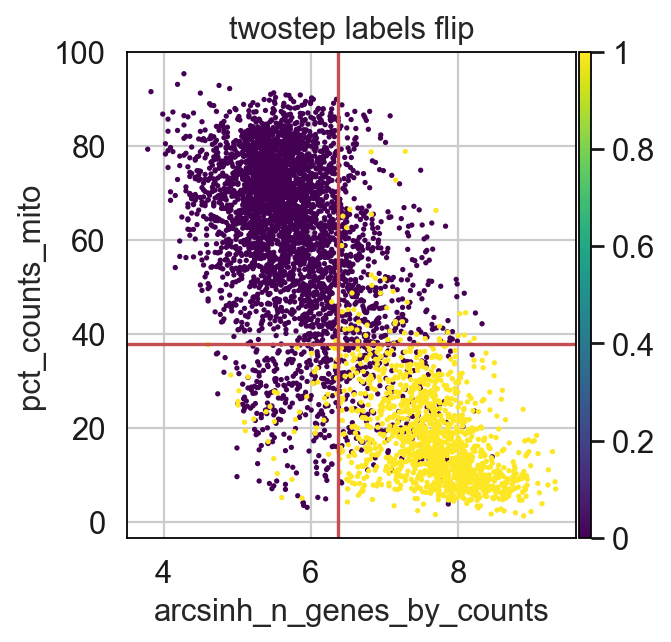

In [42]:
# look at our final labels
ax = sc.pl.scatter(adata=s1, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='twostep_labels_flip', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
plt.show()

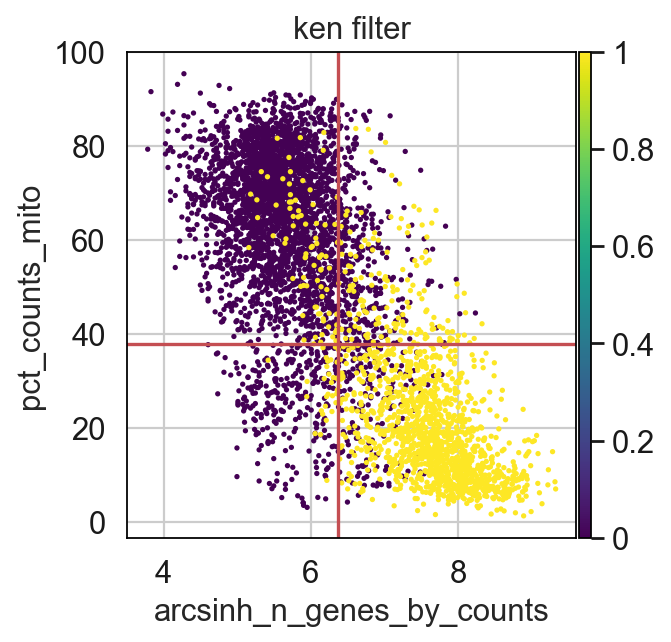

In [43]:
# compare to Ken's labels
ax = sc.pl.scatter(adata=s1, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
plt.show()

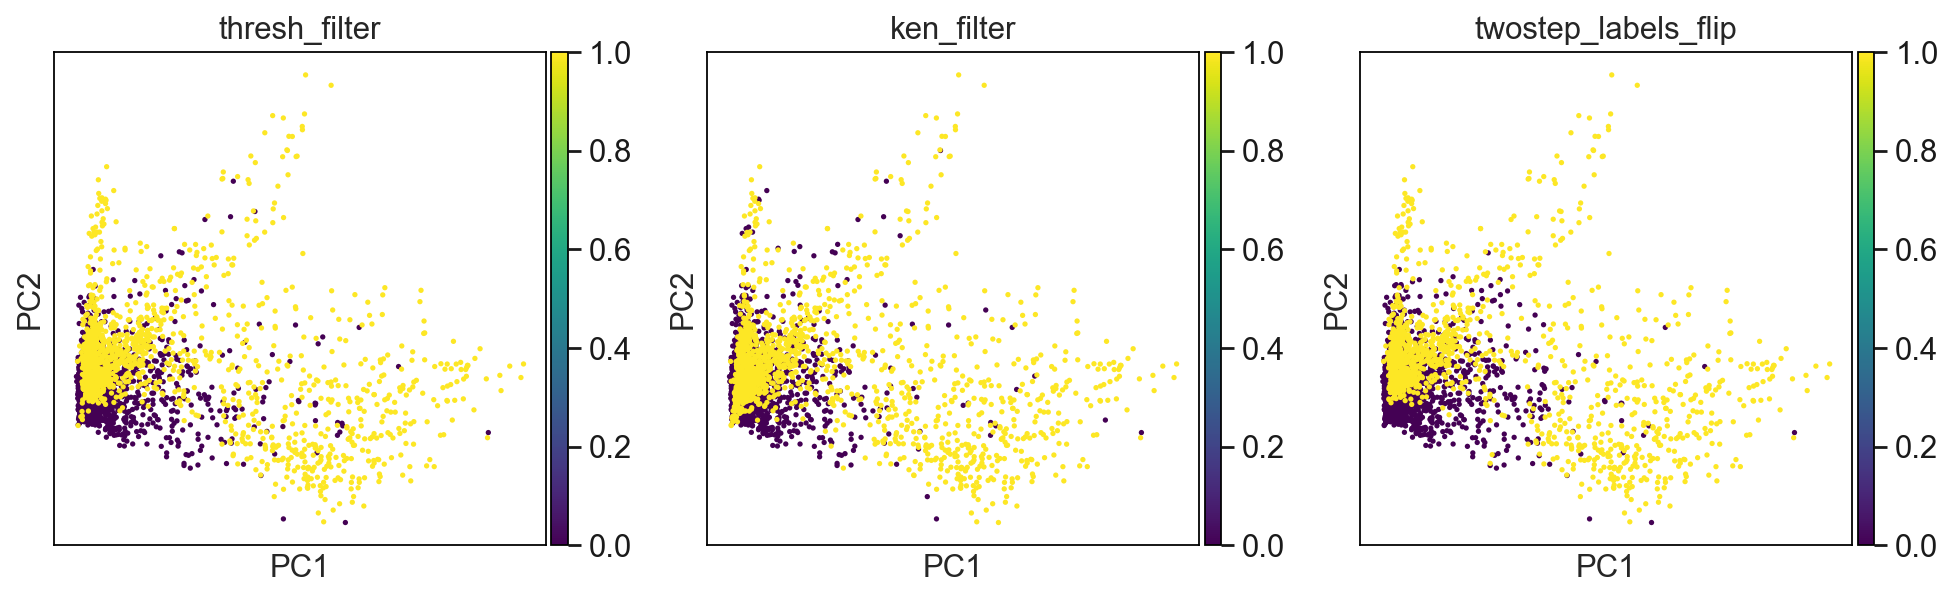

In [44]:
# compare two-step results to threshold filtering and Ken's labels
sc.pl.pca(s1, color=['thresh_filter','ken_filter','twostep_labels_flip'])

In [45]:
len(set(s1.obs_names[s1.obs['twostep_labels_flip']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

180

In [46]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['twostep_labels_flip']==1])))

378

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [47]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'same'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['twostep_labels_flip']==0), 'compare'] = 'ken'
s1.obs.loc[(s1.obs['twostep_labels_flip']==1) & (s1.obs['ken_filter']==0), 'compare'] = 'twostep'

In [48]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['ken_filter']==1,:].copy()
s1_twostep = s1[s1.obs['twostep_labels_flip']==1,:].copy()

In [49]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^mt-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


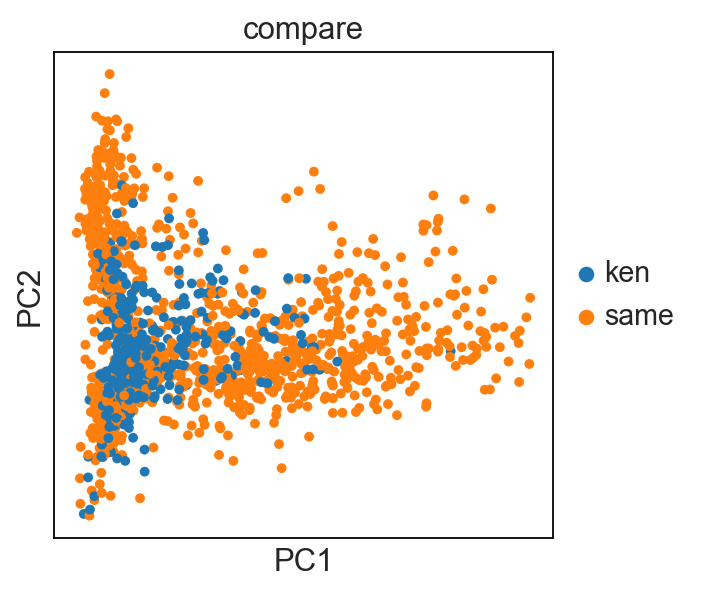

CPU times: user 1.41 s, sys: 340 ms, total: 1.75 s
Wall time: 306 ms


In [50]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [51]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

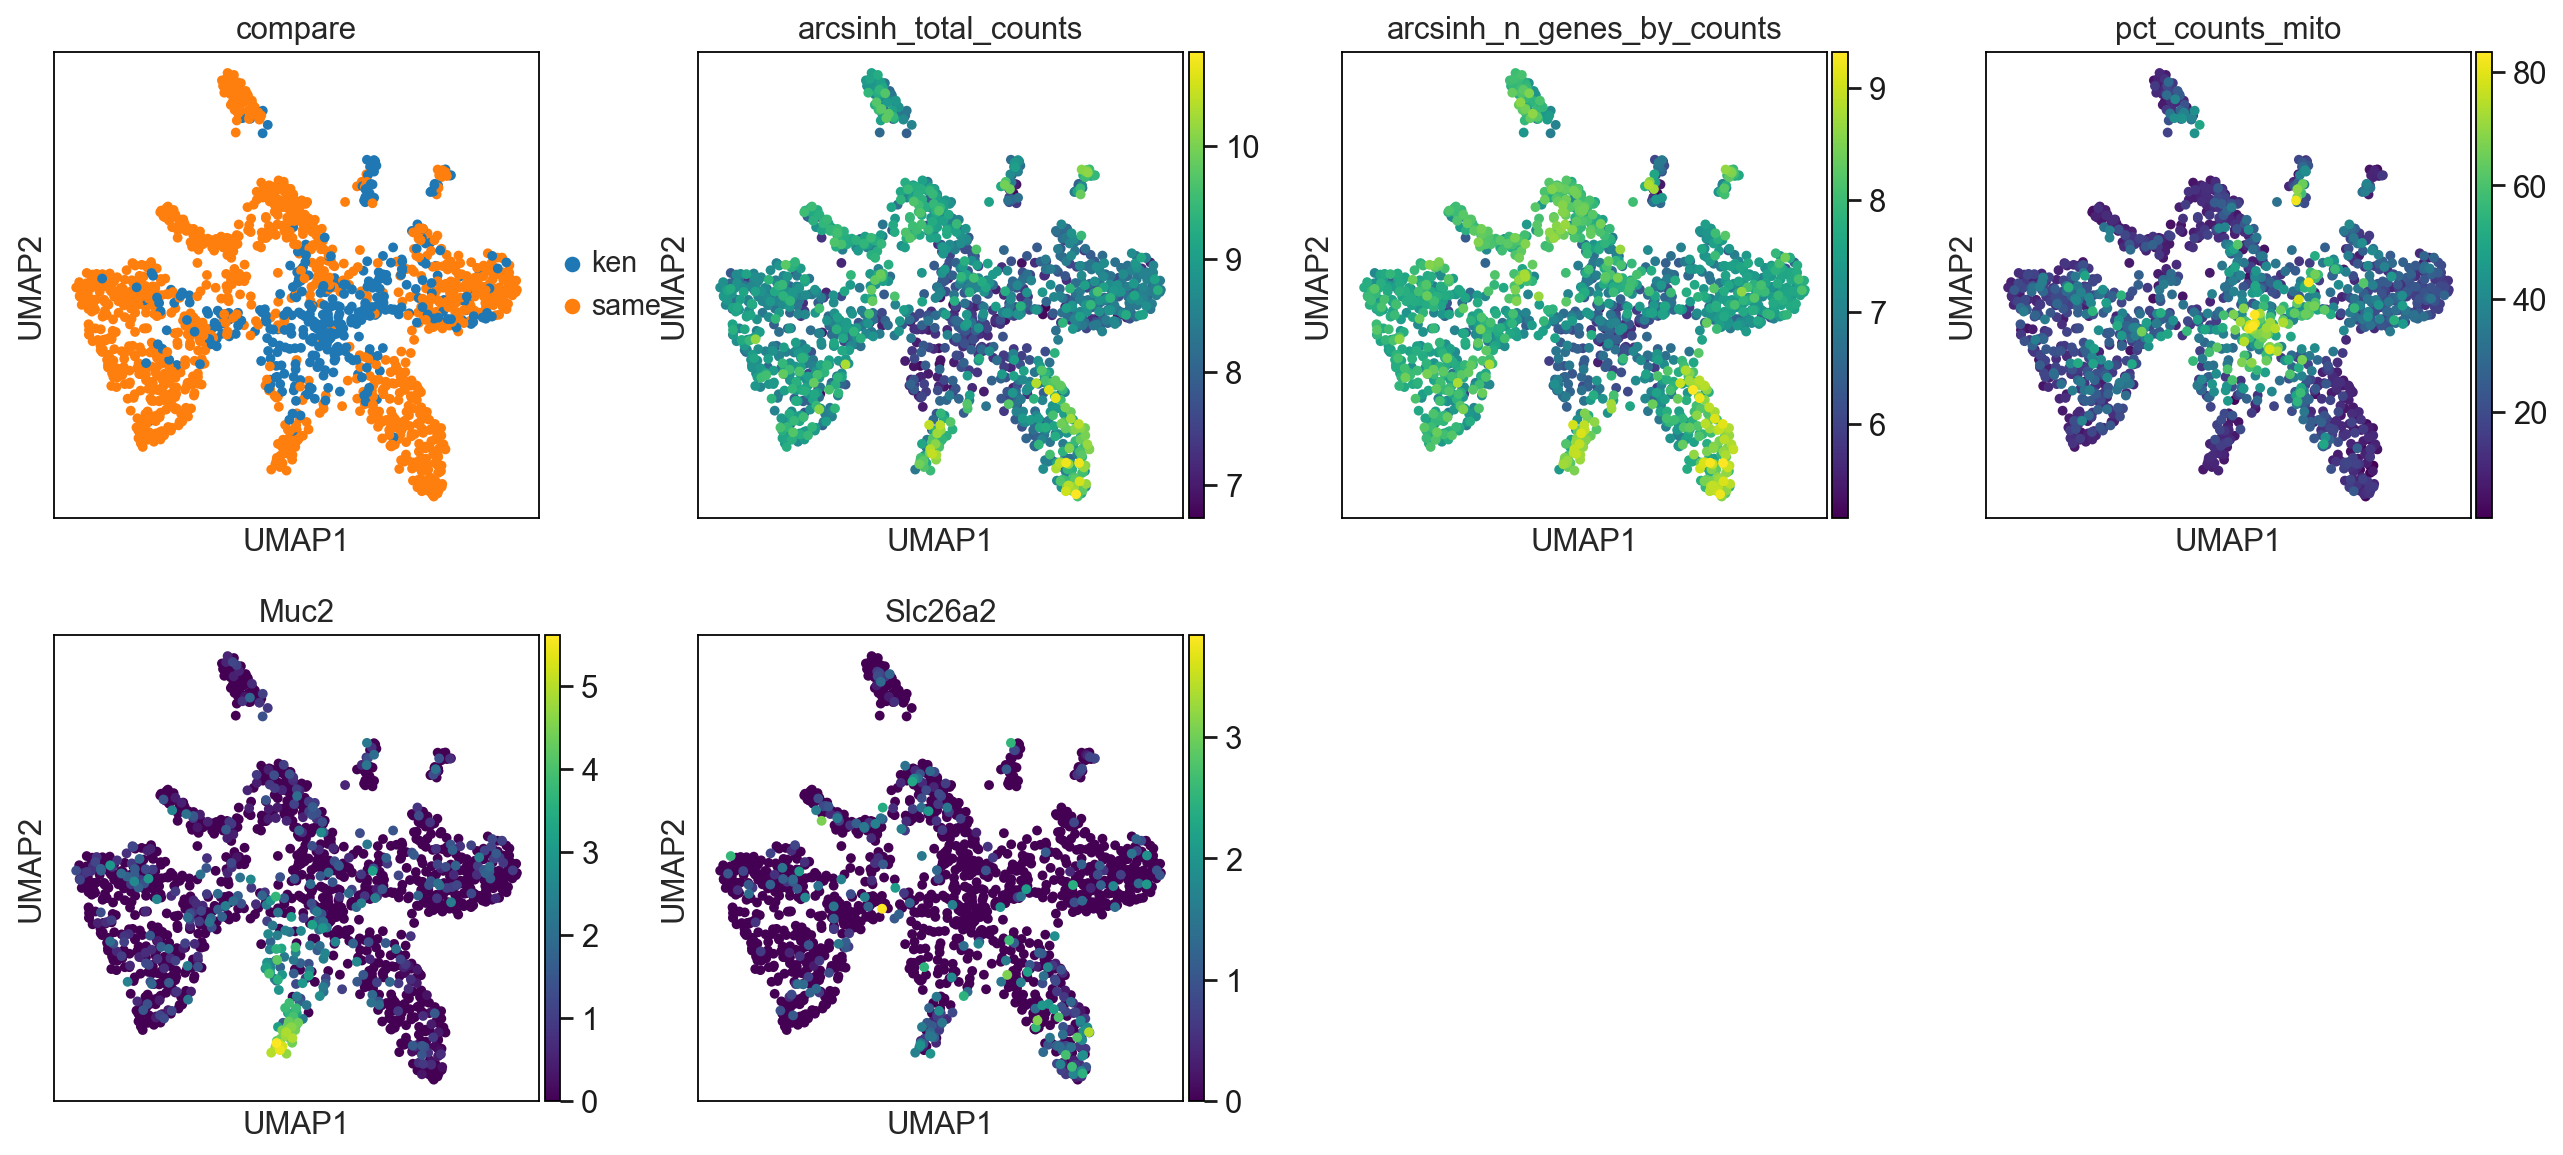

In [52]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Slc26a2'])

---
#### Now do the same on TwoStep results

In [53]:
# preprocess
s1_twostep.X = s1_twostep.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_twostep, min_cells=1)
recipe_fcc(s1_twostep, X_final='arcsinh_norm', mito_names='^mt-')
s1_twostep.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_twostep.obs['n_genes_by_counts'])

... storing 'compare' as categorical


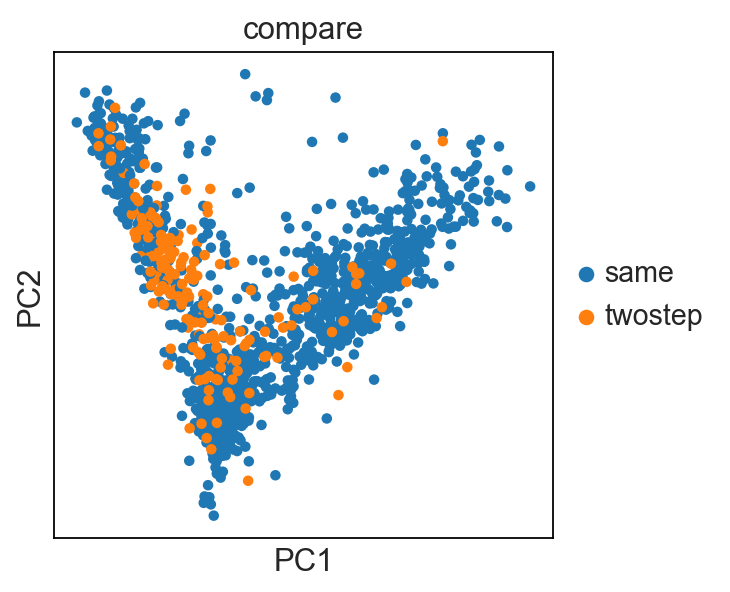

CPU times: user 1.4 s, sys: 288 ms, total: 1.69 s
Wall time: 280 ms


In [54]:
%%time
sc.tl.pca(s1_twostep, n_comps=10)
sc.pl.pca(s1_twostep, color=['compare'])

In [55]:
sc.pp.neighbors(s1_twostep, n_neighbors=int(np.sqrt(s1_twostep.n_obs)))
sc.tl.umap(s1_twostep)

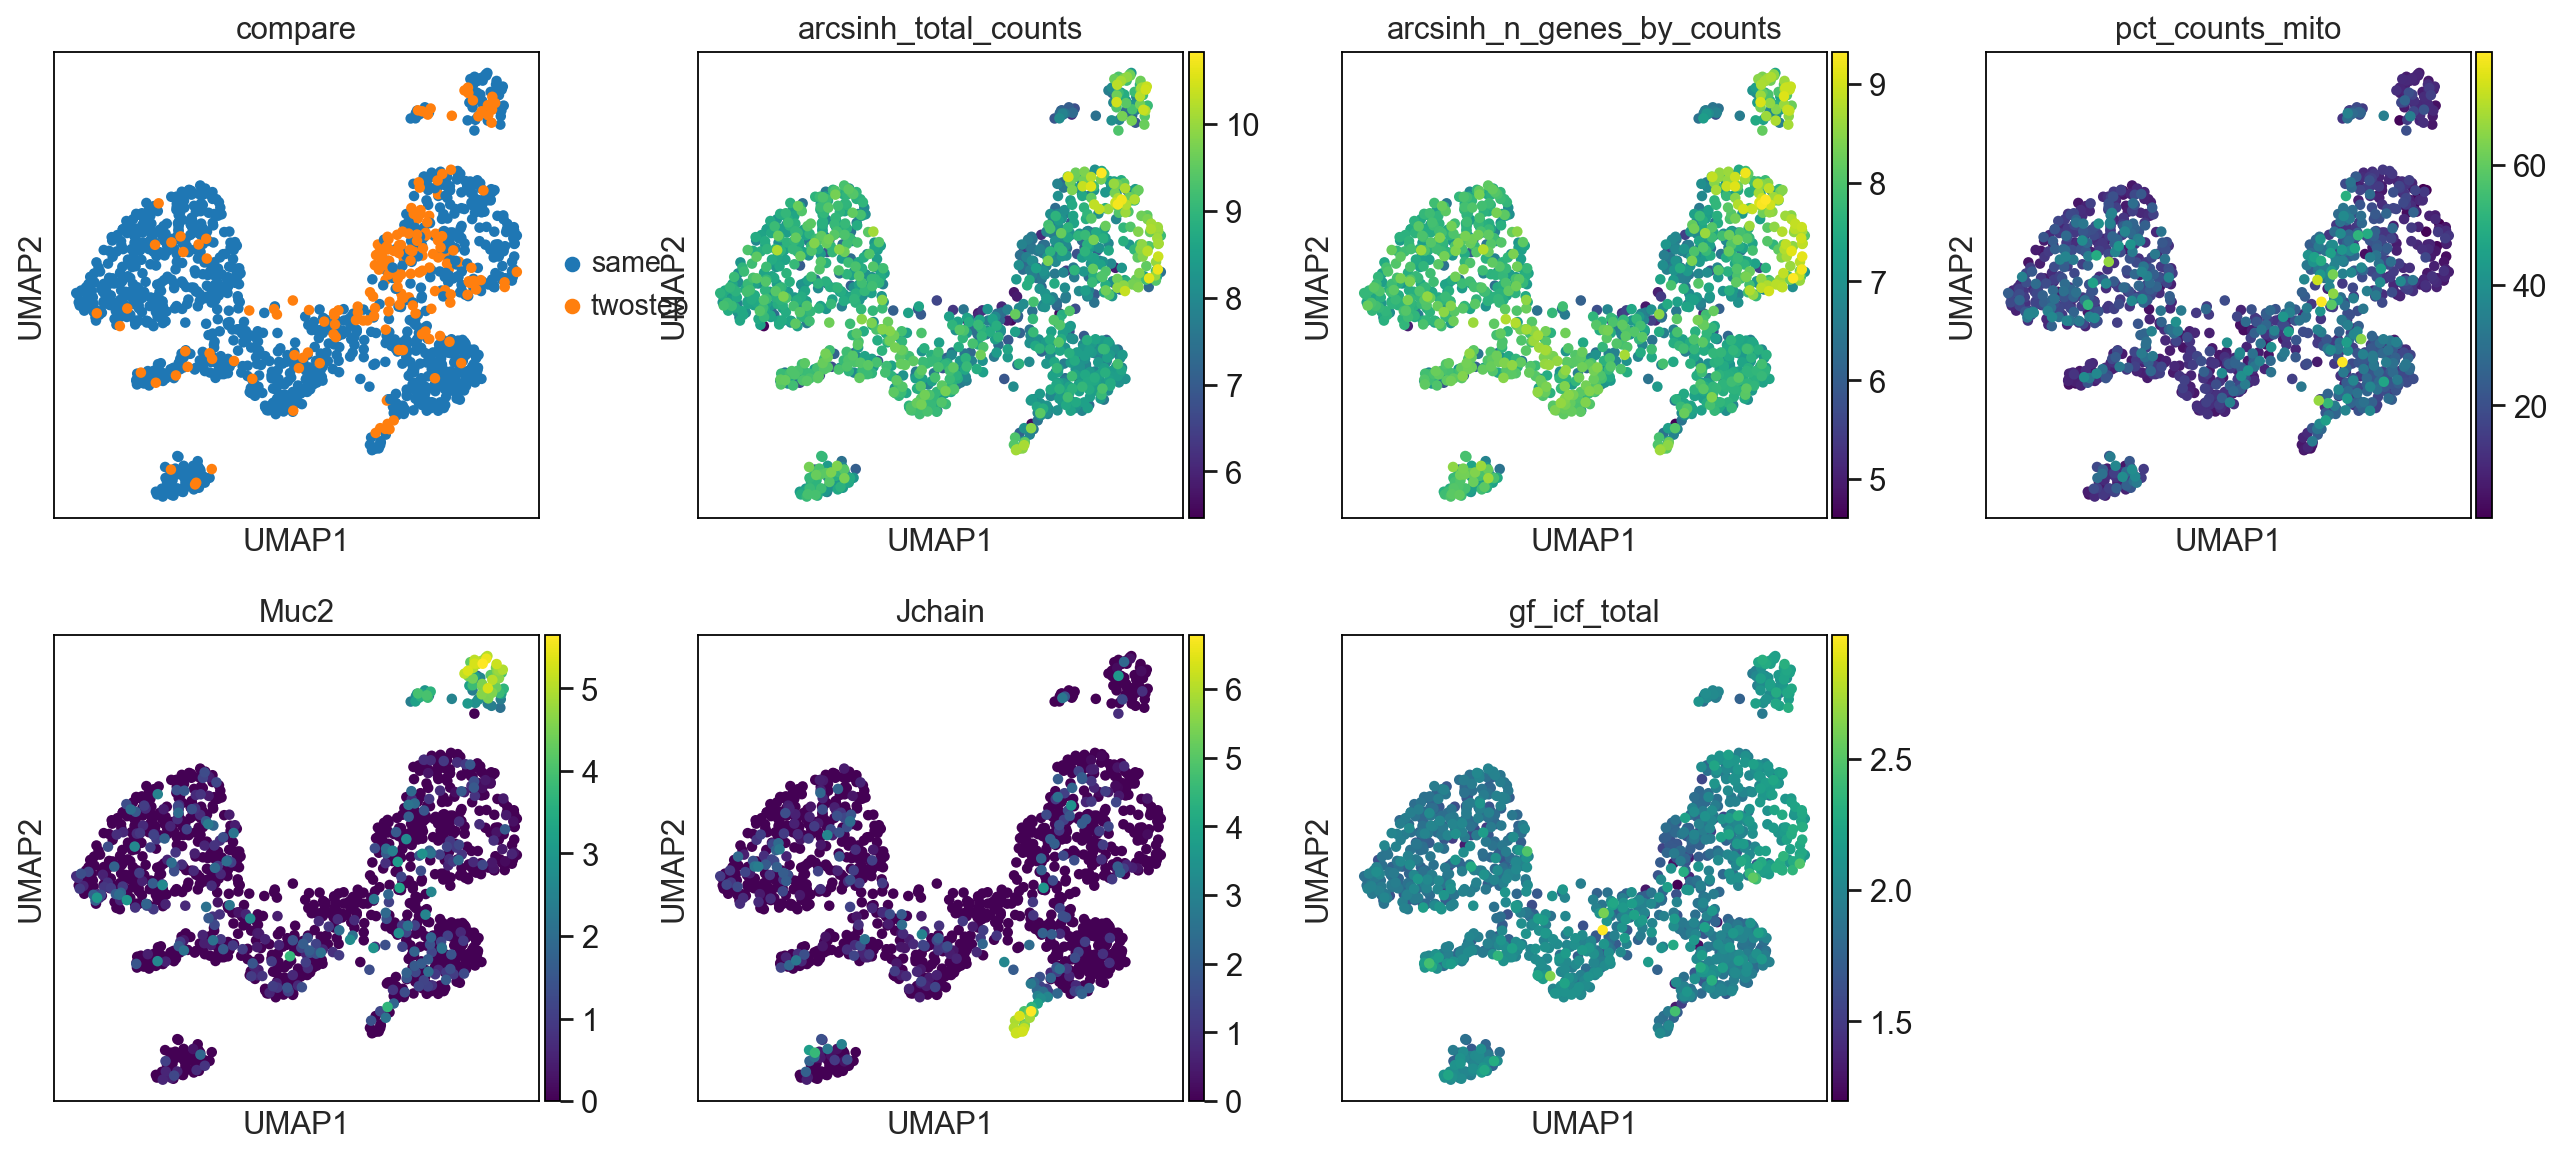

In [56]:
sc.pl.umap(s1_twostep, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total'])